In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import rcParams

# Train Models

In [3]:
EPOCHS = 1000
LR = 1
MANUAL_SEED = 1
ACC_SPACING = 100

act_fn_by_name = {
    "tanh": nn.Tanh,
    "relu": nn.ReLU,
    "identity": nn. Identity
}

model_name_to_config = {
    "0_hidden_layer" : [()], 
    "1_hidden_layer_1_unit_identity" : [(1,), "identity"],
    "1_hidden_layer_2_unit_identity" : [(2,), "identity"], 
    "1_hidden_layer_3_unit_identity" : [(3,), "identity"], 
    "1_hidden_layer_10_unit_identity" : [(10,), "identity"], 
    "1_hidden_layer_1_unit_relu" : [(1,), "relu"], 
    "1_hidden_layer_1_unit_tanh" : [(1,), "tanh"], 
    "1_hidden_layer_2_unit_relu" : [(2,), "relu"], 
    "1_hidden_layer_2_unit_tanh" : [(2,), "tanh"], 
    "10_hidden_layer_3_unit_identity" : [(3,)*10, "identity"], 
}

class MLP(nn.Module):
    
    def __init__(self, hidden_units, act_fn = 'tanh'):
        super().__init__()
        hidden_layers = []
        for num_hidden in hidden_units:
            hidden_layers.append(nn.LazyLinear(num_hidden))
            hidden_layers.append(act_fn_by_name[act_fn]())
        self.hidden_layers = nn.Sequential(*hidden_layers)
        self.linear = nn.LazyLinear(1)

    def forward(self, x):
        x = self.hidden_layers(x)
        x = self.linear(x)
        return x

def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.mps.manual_seed(seed)

In [4]:
device = torch.device("mps") if torch.mps.is_available() else torch.device("cpu")
print("Device", device)

# XOR Data
xs = torch.tensor([[-1, -1], [-1, 1], [1, -1], [1, 1]], dtype = torch.float32).to(device)
ys = torch.tensor([1, 0, 0, 1], dtype = torch.float32).to(device)
loss_module = nn.BCEWithLogitsLoss()

# Train models
model_name_to_results = {}
for model_name in model_name_to_config:
    set_seed(MANUAL_SEED)
    model = MLP(*model_name_to_config[model_name]).to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr = LR)
    losses = []
    accs = []
    for epoch in range(EPOCHS+1):
        preds = model(xs).flatten()
        if epoch % 100 == 0:
            acc = (((torch.sigmoid(preds) > 0.5) == ys).sum()/ys.shape[0])
            acc = int(acc.item()*100)
            accs.append(acc)
        loss = loss_module(preds, ys)
        losses.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    # Store model parameters and per-epoch accuracies and losses
    model_name_to_results[model_name] = {
        "weights" : model.state_dict(),
        "accuracies" : accs, 
        "losses" : losses
    }

Device mps


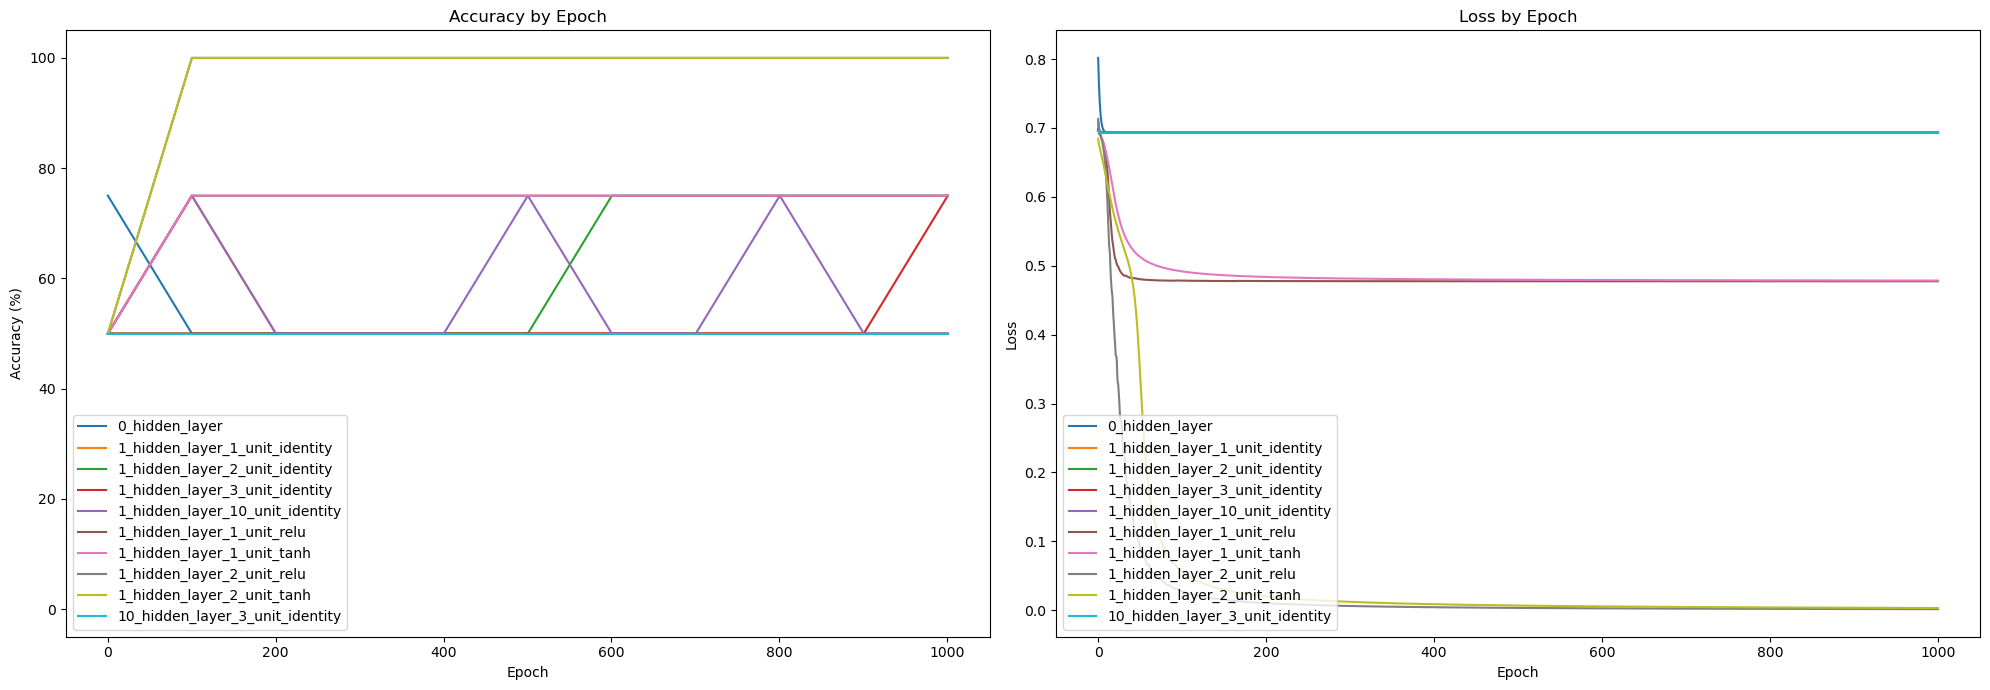

In [5]:
# Plot results
fig, axs = plt.subplots(ncols = 2, figsize = (20,7))
for model_name in model_name_to_results:
    accs = model_name_to_results[model_name]["accuracies"]
    axs[0].plot(np.linspace(0, EPOCHS + 1, len(accs)), accs, label = model_name)
    axs[1].plot(model_name_to_results[model_name]["losses"], label = model_name)
for ax in axs:
    ax.set_xlabel("Epoch")
    ax.legend()
axs[0].set_ylim([-5,105])
axs[0].set_title("Accuracy by Epoch")
axs[1].set_title("Loss by Epoch")
axs[0].set_ylabel("Accuracy (%)")
axs[1].set_ylabel("Loss")
fig.tight_layout()
plt.savefig("training_stats.png");

# 2D Visualization

In [7]:
def relu(x):
    return x * (x > 0)

def create_fig(title = None, ax_min = -5, ax_max = 5):
    fig, ax = plt.subplots()
    ax.set_xlim(ax_min, ax_max)
    ax.set_ylim(ax_min, ax_max)
    ax.set_aspect('equal')
    ax.set_title(title)
    return fig, ax

def update(t, f, matrix = None, plot_arrows = False):
    # Define a matrix transformation
    for i, line in enumerate(lines_h):
        original_points = np.vstack([x, np.full_like(x, y[i])])
        if f == np.dot:
            transformed_points = t * np.dot(matrix, original_points) + (1 - t) * original_points
        else:
            transformed_points = t * f(original_points) + (1 - t) * original_points
        line.set_data(transformed_points[0], transformed_points[1])

    for i, line in enumerate(lines_v):
        original_points = np.vstack([np.full_like(y, x[i]), y])
        if f == np.dot:
            transformed_points = t * np.dot(matrix, original_points) + (1 - t) * original_points
        else:
            transformed_points = t * f(original_points) + (1 - t) * original_points
        line.set_data(transformed_points[0], transformed_points[1])

    if plot_arrows:
        standard_basis = np.array([[1, 0], [0, 1]])
        arrow1.set_UVC(*(t*matrix[:, 0] + (1-t)*standard_basis[:, 0])) 
        arrow2.set_UVC(*(t*matrix[:, 1] + (1-t)*standard_basis[:, 1]))  

    return lines_h + lines_v + [arrow1, arrow2]

def get_transformed_point_multistep(t, w, b, activation, x):
    t1 = np.dot(w,x)
    t2 = t1 + b
    t3 = activation(t2)
    if t == 3: 
        return t3
    else:
        timestep_to_endpoint = {0: x, 1: t1, 2: t2, 3: t3}
        lower = timestep_to_endpoint[int(t)]
        upper = timestep_to_endpoint[int(t) + 1]
        fraction = t % 1
        return fraction*upper + (1-fraction)*lower

def update_multistep(t, w, b, activation):
    for i, line in enumerate(lines_h):
        original_points = np.vstack([x, np.full_like(x, y[i])])
        transformed_points = get_transformed_point_multistep(t, w, b, activation, original_points)
        line.set_data(transformed_points[0], transformed_points[1])

    for i, line in enumerate(lines_v):
        original_points = np.vstack([np.full_like(y, x[i]), y])
        transformed_points = get_transformed_point_multistep(t, w, b, activation, original_points)
        line.set_data(transformed_points[0], transformed_points[1]) 

    original_xor_points = np.array([[-1,1,-1,1], [-1,1, 1,-1]])
    transformed_points = get_transformed_point_multistep(t, w, b, activation, original_xor_points)
    xor_points.set_offsets(transformed_points.T)

def extract_plotting_params_from_model(model_name):
    model_params = model_name_to_results[model_name]["weights"]
    hidden_w = model_params['hidden_layers.0.weight'].cpu().numpy()
    hidden_b = model_params['hidden_layers.0.bias'].cpu().numpy()[:, None]
    classifier_w = model_params['linear.weight'].cpu().numpy().flatten()
    classifier_b = model_params["linear.bias"].item()
    m = -(classifier_w[0]/classifier_w[1])
    c = -(classifier_b/classifier_w[1])
    return hidden_w, hidden_b, m, c

In [8]:
rcParams['text.usetex'] = True
grid_min, grid_max, num_steps = -3, 3, 7
demo_matrix = np.array([[2, -1], [3, 2]])

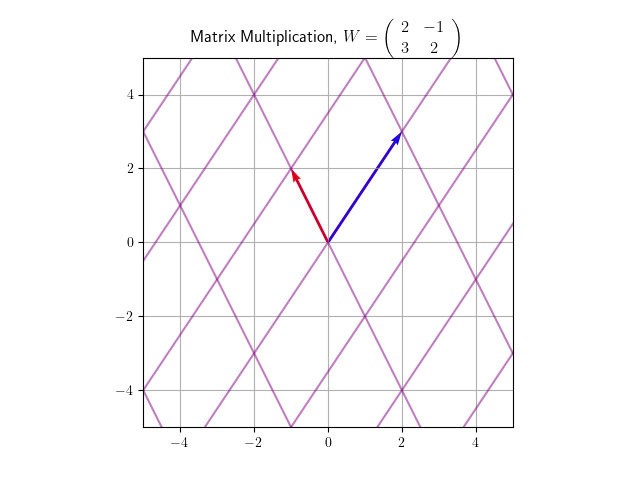

In [9]:
%matplotlib ipympl
rcParams['text.usetex'] = True
fig, ax = create_fig(r'Matrix Multiplication, $W = \left(\begin{array}{ccc}' + fr'{demo_matrix[0][0]} & {demo_matrix[0][1]} \\ {demo_matrix[1][0]} & {demo_matrix[1][1]}' + r'\end{array}\right)$')
x, y = np.linspace(grid_min, grid_max, num_steps), np.linspace(grid_min, grid_max, num_steps)
lines_h = [ax.plot(x, np.full_like(x, y_line), color='purple', alpha=0.5)[0] for y_line in y]
lines_v = [ax.plot(np.full_like(y, x_line), y, color='purple', alpha=0.5)[0] for x_line in x]
arrow1 = ax.quiver(0, 0, 1, 0, angles='xy', scale_units='xy', scale=1, color='blue')
arrow2 = ax.quiver(0, 0, 0, 1, angles='xy', scale_units='xy', scale=1, color='red')
ani = animation.FuncAnimation(fig, update, frames=np.linspace(0, 1, 100), interval=50, fargs = (np.dot, demo_matrix, True,), repeat = False)
ax.grid()
ani.save('matmul.gif', writer='pillow') 
plt.show();

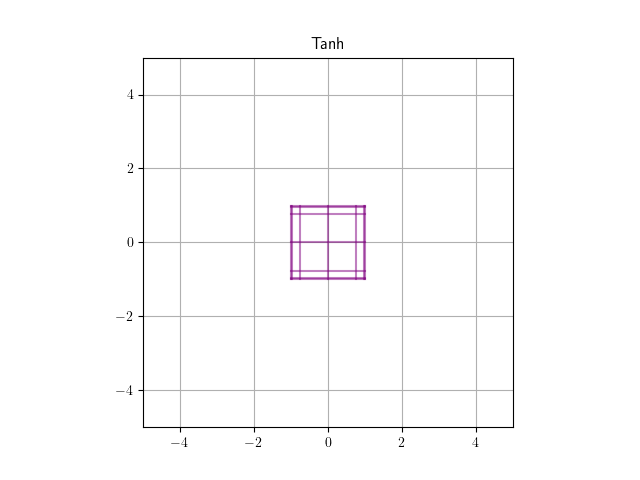

In [10]:
fig, ax = create_fig('Tanh')
x, y = np.linspace(grid_min, grid_max, num_steps), np.linspace(grid_min, grid_max, num_steps)
lines_h = [ax.plot(x, np.full_like(x, y_line), color='purple', alpha=0.5)[0] for y_line in y]
lines_v = [ax.plot(np.full_like(y, x_line), y, color='purple', alpha=0.5)[0] for x_line in x]
ani = animation.FuncAnimation(fig, update, frames=np.linspace(0, 1, 100), interval=50, fargs = (np.tanh,), repeat = False)
ax.grid()
ani.save('tanh.gif', writer='pillow') 
plt.show();

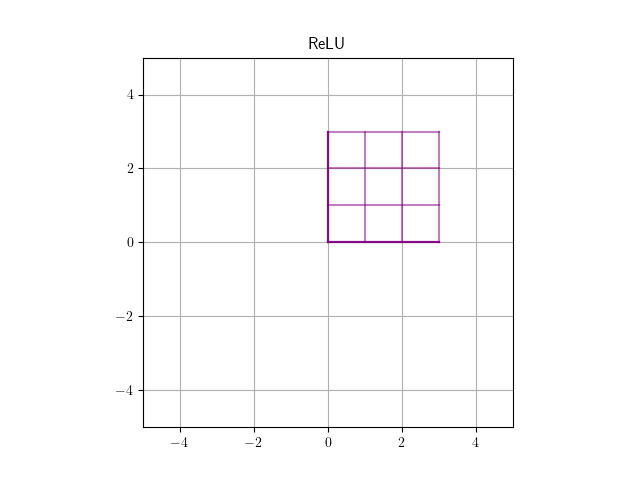

In [11]:
fig, ax = create_fig('ReLU')
x, y = np.linspace(grid_min, grid_max, num_steps), np.linspace(grid_min, grid_max, num_steps)
lines_h = [ax.plot(x, np.full_like(x, y_line), color='purple', alpha=0.5)[0] for y_line in y]
lines_v = [ax.plot(np.full_like(y, x_line), y, color='purple', alpha=0.5)[0] for x_line in x]
ani = animation.FuncAnimation(fig, update, frames=np.linspace(0, 1, 100), interval=50, fargs = (relu,), repeat = False)
ax.grid()
ani.save('relu.gif', writer='pillow') 
plt.show();

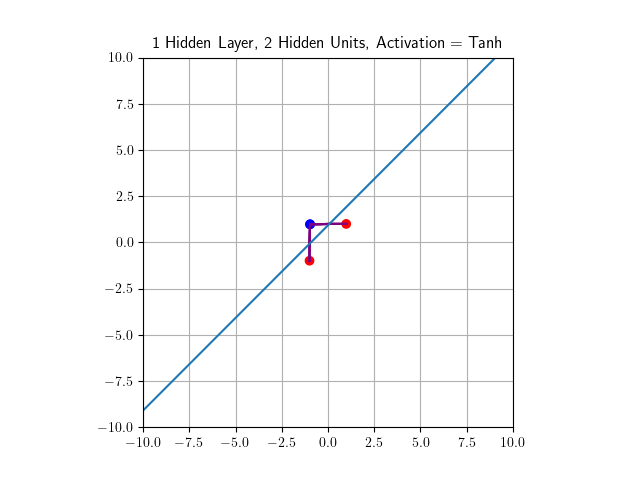

In [12]:
fig_min, fig_max = -10, 10
hidden_w, hidden_b, m, c = extract_plotting_params_from_model('1_hidden_layer_2_unit_tanh')
activation = np.tanh
fig, ax = create_fig('1 Hidden Layer, 2 Hidden Units, Activation = Tanh', -10, 10)
x, y = np.linspace(grid_min, grid_max, num_steps), np.linspace(grid_min, grid_max, num_steps)
lines_h = [ax.plot(x, np.full_like(x, y_line), color='purple', alpha=0.5)[0] for y_line in y]
lines_v = [ax.plot(np.full_like(y, x_line), y, color='purple', alpha=0.5)[0] for x_line in x]
xor_points = ax.scatter([-1,1,-1,1], [-1,1, 1,-1], color = ['blue', 'blue', 'red', 'red'])
ani = animation.FuncAnimation(fig, update_multistep, frames=np.linspace(0, 3, 100), interval=50, fargs = (hidden_w, hidden_b, activation, ), repeat = False)
fig_xs = np.linspace(fig_min, fig_max, 100)
fig_ys = m*fig_xs + c
ax.plot(fig_xs, fig_ys)
ax.grid()
ani.save('model_tanh.gif', writer='pillow')
plt.show();

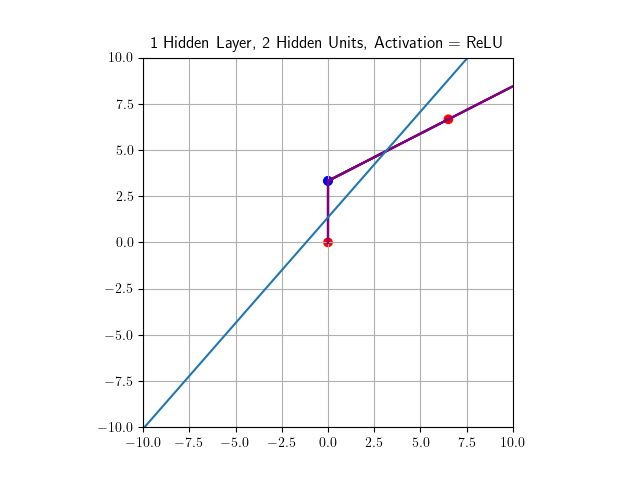

In [13]:
fig_min, fig_max = -10, 10
hidden_w, hidden_b, m, c = extract_plotting_params_from_model('1_hidden_layer_2_unit_relu')
activation = relu
fig, ax = create_fig('1 Hidden Layer, 2 Hidden Units, Activation = ReLU', -10, 10)
x, y = np.linspace(grid_min, grid_max, num_steps), np.linspace(grid_min, grid_max, num_steps)
lines_h = [ax.plot(x, np.full_like(x, y_line), color='purple', alpha=0.5)[0] for y_line in y]
lines_v = [ax.plot(np.full_like(y, x_line), y, color='purple', alpha=0.5)[0] for x_line in x]
xor_points = ax.scatter([-1,1,-1,1], [-1,1, 1,-1], color = ['blue', 'blue', 'red', 'red'])
ani = animation.FuncAnimation(fig, update_multistep, frames=np.linspace(0, 3, 100), interval=50, fargs = (hidden_w, hidden_b, activation, ), repeat = False)
fig_xs = np.linspace(fig_min, fig_max, 100)
fig_ys = m*fig_xs + c
ax.plot(fig_xs, fig_ys)
ax.grid()
ani.save('model_relu.gif', writer='pillow')
plt.show();